# Imports

In [22]:
import os
import sys
from functools import reduce
from pathlib import Path

sys.path.extend(['/Users/fabianloewe/Projects/master-thesis/tools/aletheia'])

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import aletheialib.attacks as attacks
import aletheialib.options.tools as tools

# Prepare data

In [3]:
EMBEDDING_METHODS = [
    'MobiStego', 'Passlok', 'Pictograph', 'PixelKnot', 'PocketStego', 'SteganographyM'
]

BASE_PATH = Path('../datasets/StegoAppDB_stegos_20240309-030352')

df = pd.read_csv(BASE_PATH / 'StegoAppDB_stegos_20240309-030352_stego_directory.csv')

dfs = {m: df[df['embedding_method'] == m] for m in EMBEDDING_METHODS}
dfs_image_pairs = {
    m: list((BASE_PATH / 'covers' / ci, BASE_PATH / 'stegos' / si) for ci, si in
            zip(dfs[m]['cover_image_filename'], dfs[m]['image_filename']))
    for m in EMBEDDING_METHODS
}

# Compute file size diffs

In [4]:
all_size_diffs = {
    m: attacks.size_diff(image_pairs)
    for m, image_pairs in dfs_image_pairs.items()
}

<Axes: xlabel='File Size Diff (Percentage)', ylabel='Method'>

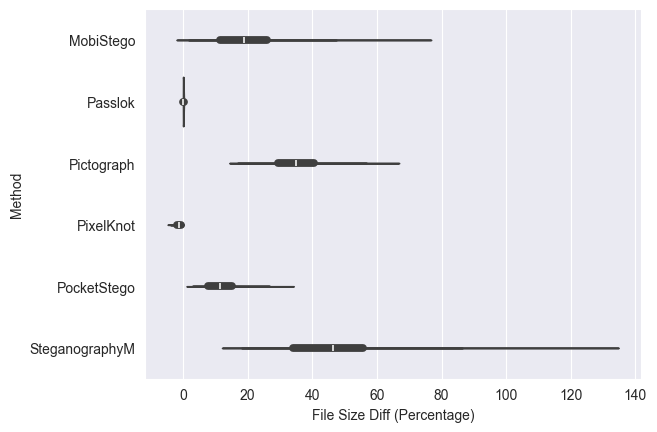

In [24]:
size_diffs_df = pd.DataFrame(((method, *size_diff) for method, size_diffs in all_size_diffs.items() for size_diff in size_diffs),
                             columns=['Method', 'Cover', 'Stego', 'File Size Diff (Bytes)',
                                      'File Size Diff (Percentage)'])
sns.violinplot(data=size_diffs_df, x='File Size Diff (Percentage)', y='Method')

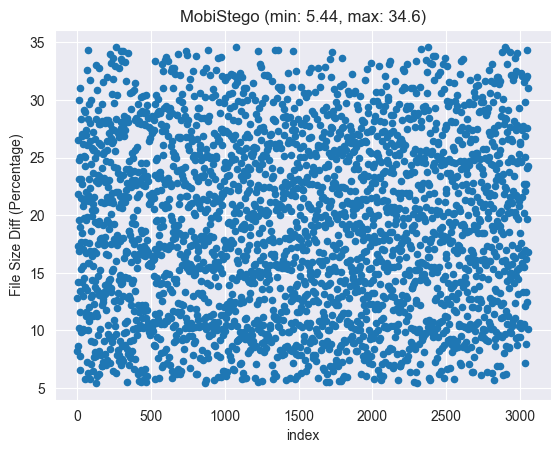

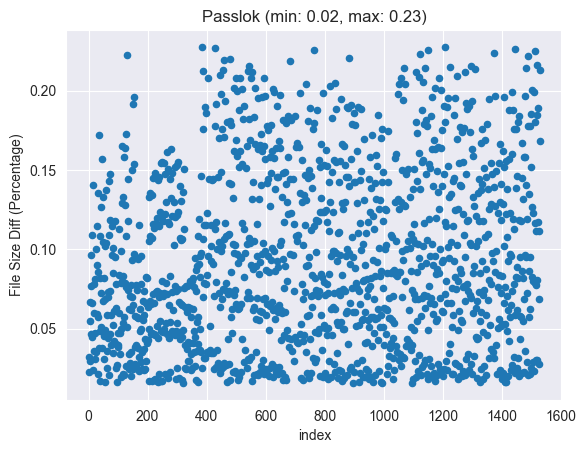

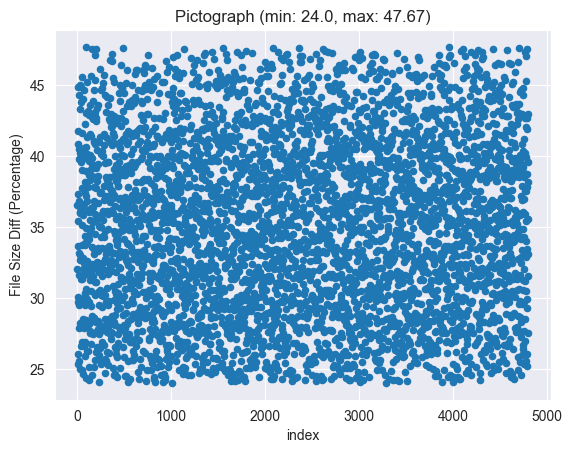

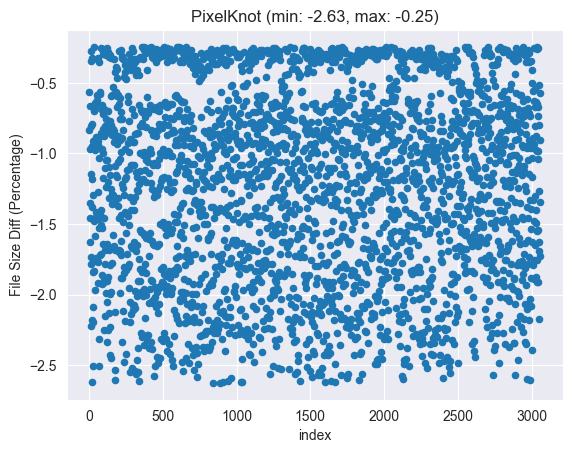

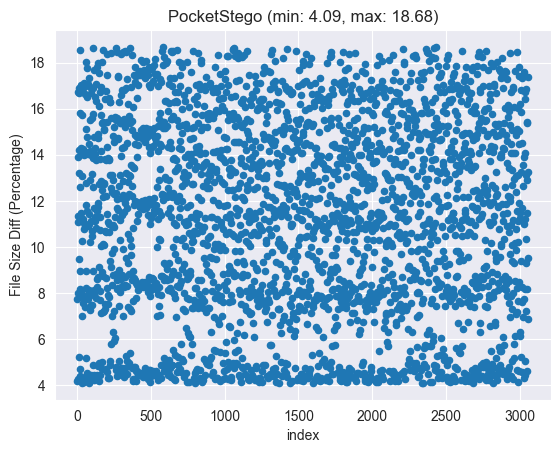

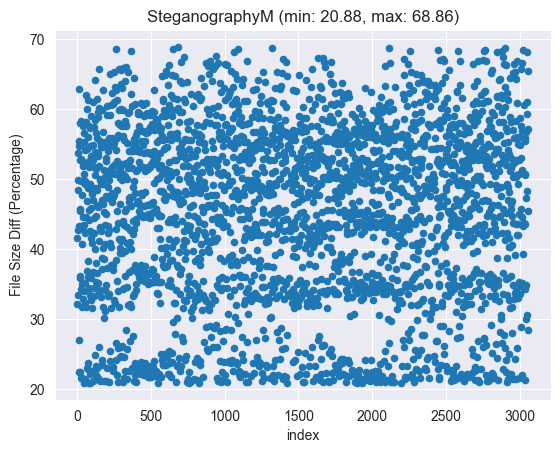

In [6]:
THRESHOLD_LOW = 0.05
THRESHOLD_HIGH = 0.95

size_diffs_no_outliers = {}
for method, size_diffs in all_size_diffs.items():
    size_diffs_df = pd.DataFrame(size_diffs,
                                 columns=['Cover', 'Stego', 'File Size Diff (Bytes)', 'File Size Diff (Percentage)'])
    size_diffs_df.sort_values(by='File Size Diff (Percentage)', inplace=True)

    mean_above_0 = size_diffs_df['File Size Diff (Percentage)'].mean() > 0
    q_low = size_diffs_df['File Size Diff (Percentage)'].quantile(THRESHOLD_LOW) if mean_above_0 else size_diffs_df[
        'File Size Diff (Percentage)'].quantile(THRESHOLD_HIGH)
    q_high = size_diffs_df['File Size Diff (Percentage)'].quantile(THRESHOLD_HIGH) if mean_above_0 else size_diffs_df[
        'File Size Diff (Percentage)'].quantile(THRESHOLD_LOW)
    size_diffs_df = (size_diffs_df[(size_diffs_df['File Size Diff (Percentage)'] > q_low) & (
            size_diffs_df['File Size Diff (Percentage)'] < q_high)]
                     if mean_above_0
                     else size_diffs_df[(size_diffs_df['File Size Diff (Percentage)'] < q_low) & (
            size_diffs_df['File Size Diff (Percentage)'] > q_high)])
    size_diffs_no_outliers[method] = size_diffs_df
    size_diffs_df.reset_index()
    size_diffs_df['index'] = size_diffs_df.index
    size_diffs_df.plot.scatter(x='index', y='File Size Diff (Percentage)',
                               title=f'{method} (min: {round(size_diffs_df["File Size Diff (Percentage)"].min(), 2)}, max: {round(size_diffs_df["File Size Diff (Percentage)"].max(), 2)})')

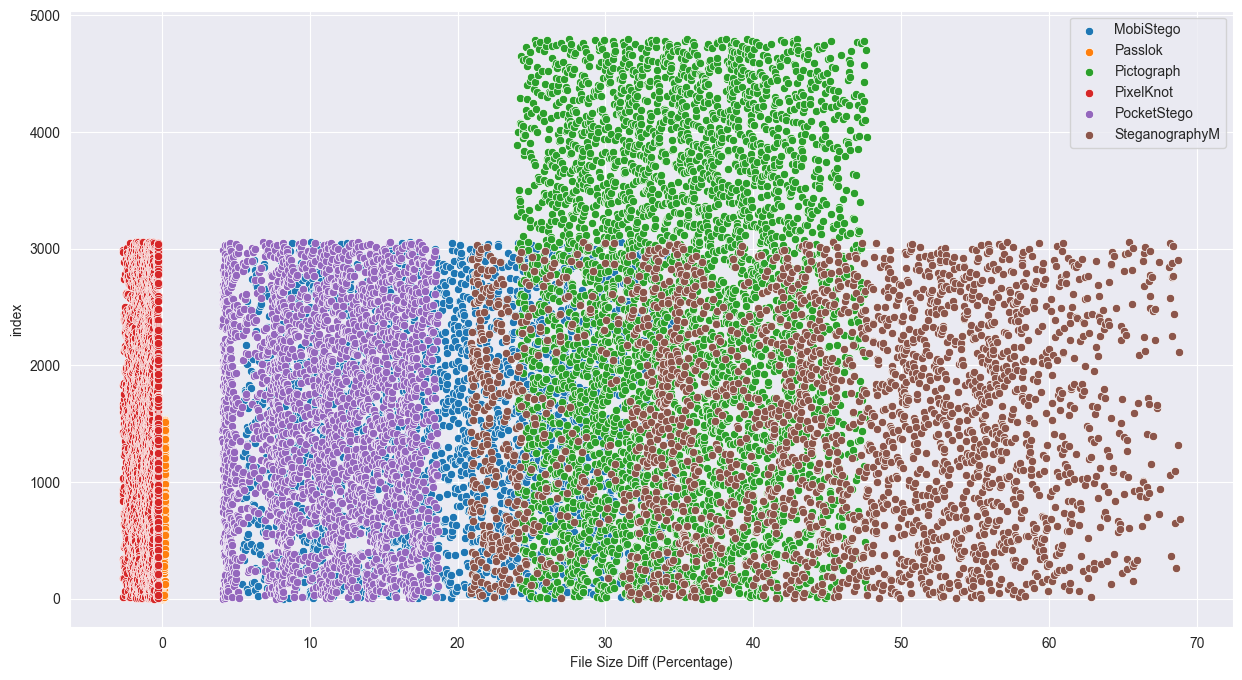

In [19]:
plt.figure(figsize=(15, 8))
for method, size_diffs in size_diffs_no_outliers.items():
    sns.scatterplot(data=size_diffs, x='File Size Diff (Percentage)', y='index', legend='brief', label=method)
plt.show()